In [3]:
import numpy as np
from dtw import dtw
from scipy.io import loadmat
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Settings

## General settings

In [4]:
settings = {}
settings['cdrtype'] = 0
settings['diffh'] = 9
settings['method'] = 'multiparametric'

def sett2str(sett):
    sett_str = ''
    for key, value in sett.items():
        sett_str += '%s%s_' % (key, value)
    return sett_str[:-1]

## Path settings

In [5]:
save_path = 'results'
load_path = os.path.join('results', 'timeseries')


# Load timeseries

In [6]:
ts = None

for cdrtype in [1, 2, 3, 4]:
    settings['cdrtype'] = cdrtype
    
    file_path = os.path.join(load_path, 'ts_%s.mat' % sett2str(settings))
    
    if settings['method'] == 'multiparametric':
        ts_i = loadmat(file_path)['ts']
    else:
        ts_i = np.expand_dims(loadmat(file_path)['ts'], axis=2)
    
    if ts is None:
        ts = ts_i
    else:
        ts = np.concatenate((ts, ts_i), axis=2)

y = np.ones((ts.shape[0],))
y[int(y.shape[0]/2):] = 0

print(ts.shape, y.shape)

(20000, 42, 8) (20000,)


# Train-Test split

In [7]:
ts_tr, ts_te, y_tr, y_te = train_test_split(ts, y, test_size=0.2, random_state=1)

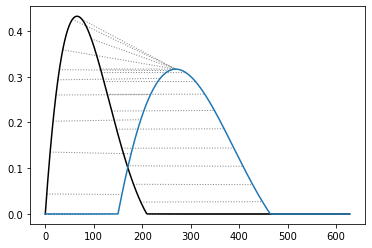

In [8]:
t = np.arange(0, 2*np.pi, 0.01)
x = np.zeros(t.shape)
y = np.zeros(t.shape)

filt_x = (t>0) & (t<np.pi/1.5)
x[filt_x] = np.sin(1.5*t)[filt_x]*np.exp(-t)[filt_x]

filt_y = (t>1.5) & (t<(1.5+np.pi))
y[filt_y] = np.sin(t-1.5)[filt_y]*np.exp(-t/2.5)[filt_y]

alignment = dtw(x, y, 
                keep_internals=True,
                distance_only=False)

alignment.plot(type="twoway")

# plt.savefig('match_sample.png', dpi=200)

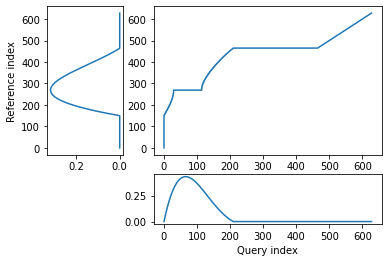

In [9]:
alignment.plot(type="threeway")

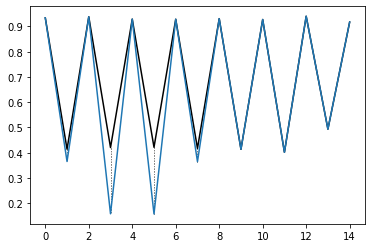

In [10]:
i_user = 1
j_user = 1200
k = 0
lim = 15
alignment = dtw(ts_tr[i_user, :lim, k], ts_tr[j_user, :lim, k], 
                keep_internals=True,
                distance_only=False)

alignment.plot(type="twoway")

# Pre-compute distance matrix

In [ ]:
n_user_tr = ts_tr.shape[0]
user_user_dist_mat_tr = np.zeros((n_user_tr, n_user_tr))

for i_user in tqdm(range(n_user_tr)):
    for j_user in range(i_user, n_user_tr):
        alignment = dtw(ts_tr[i_user], ts_tr[j_user], 
                        keep_internals=False,
                        distance_only=True)
        dist = alignment.distance

        user_user_dist_mat_tr[i_user, j_user] = dist
        user_user_dist_mat_tr[j_user, i_user] = dist

  1%|▏         | 231/16000 [29:12<32:23:29,  7.39s/it]

In [8]:
n_user_tr = ts_tr.shape[0]
n_user_te = ts_te.shape[0]
user_user_dist_mat_te = np.zeros((n_user_te, n_user_tr))

for i_user in tqdm(range(n_user_te)):
    for j_user in range(n_user_tr):
        alignment = dtw(ts_te[i_user], ts_tr[j_user], 
                        keep_internals=False,
                        distance_only=True)

        user_user_dist_mat_te[i_user, j_user] = alignment.distance


100%|██████████| 200/200 [05:27<00:00,  1.64s/it]


# KNN

In [9]:
nn_list = range(2, 50)
acc = []

for nn in nn_list:
    knn = KNeighborsClassifier(n_neighbors=nn, metric='precomputed')

    knn.fit(user_user_dist_mat_tr, y_tr)
    
    y_pr = knn.predict(user_user_dist_mat_te)

    acc += [np.sum(y_pr == y_te)/y_pr.shape[0]]
    
print(np.max(acc))
print(nn_list[np.argmax(acc)])

0.85
2


Text(0, 0.5, 'Acuuracy')

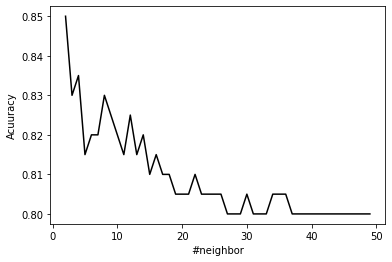

In [10]:
plt.plot(nn_list, acc, color='k')

plt.xlabel('#neighbor')
plt.ylabel('Acuuracy')